In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

In [2]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm_layer = nn.LSTM(input_size=9, num_layers=3, hidden_size=1024, batch_first=True, dropout=0.2)
        self.linear_layer = nn.Linear(in_features=1024, out_features=30)

    def forward(self, x):
        out, (h_n, h_c) = self.lstm_layer(x, None)
        out = self.linear_layer(out)
        return out

In [3]:
data1 = pd.read_csv("dataSet/trainDaily/600521.SH.csv")
data2 = pd.read_csv("dataSet/testDaily/600521.SH.csv")
data = data1.append(data2)
data.to_csv("600521.csv", index=None)

In [4]:
data = pd.read_csv("600521.csv")
data.drop(columns="trade_date", inplace=True)
max_s = data.max(axis=0)
close_max = max_s["close"]
print(max_s)
print(close_max)
data = data.div(max_s, axis=1)
data = data - 0.0001
print(data)
data.to_csv("test.csv", index=None)
print(data.max(axis=0))
print(data.min(axis=0))

open              44.310
high              45.700
low               43.220
close             44.830
pre_close         44.830
change             4.080
pct_chg           10.030
vol          1035140.800
amount       2218314.292
dtype: float64
44.83
          open      high       low     close  pre_close    change   pct_chg  \
0     0.579905  0.572767  0.594532  0.577861   0.579869 -0.022159 -0.034995   
1     0.586675  0.570797  0.586897  0.572731   0.577861 -0.056473 -0.088834   
2     0.579453  0.565983  0.582963  0.574738   0.572731  0.021959  0.034795   
3     0.582161  0.579550  0.596846  0.579200   0.574738  0.048920  0.077667   
4     0.572231  0.625064  0.586665  0.610875   0.579200  0.347939  0.545264   
...        ...       ...       ...       ...        ...       ...       ...   
2912  0.455779  0.450009  0.464037  0.452722   0.448260  0.048920  0.099102   
2913  0.459164  0.452416  0.464268  0.448260   0.452722 -0.049120 -0.098325   
2914  0.453297  0.444539  0.460798  0.44669

In [19]:
from tqdm import tqdm
test_num = 360
output_num = 30
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# data = pd.read_csv("600521.csv")
train_num = len(data) - test_num - 30
net = LSTM()
loss_function = nn.MSELoss()
loss_function = loss_function.cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)#建立优化器实例
loss = []
net = net.cuda()
for i in range(0, train_num):
    optimizer.zero_grad()
    trainData = data[i:i + 360]
    testData = data[i + 360:i + 390]
    testData = testData["close"]
    train_data = torch.tensor(trainData.values) .unsqueeze(dim=0) # 三维， [1, 360, 9]
    test_data = torch.tensor(testData.values) # 一维 [360]

    train_data = train_data.to(torch.float32)
    test_data = test_data.to(torch.float32)

    # train_data.to(device)
    # test_data.to(device)

    train_data.cuda()
    test_data.cuda()

    output = net(train_data.cuda())
    # output.to(device)
    output = output.squeeze(0)
    output = torch.index_select(output.cuda(), dim=0, index=torch.tensor([359]).cuda())
    output = output.squeeze(0)

    single_loss = loss_function(output.cuda(), test_data.cuda())
    single_loss.backward()
    optimizer.step()

    errors = 0
    for j in range(0, 30):
        errors = errors + (test_data[j] - output[j])
    loss.append(errors)
    print(i, "   ", errors)


# i = 1
# train_data = data[i:i + 360]
# train_data = train_data["close"]
# train_data = torch.tensor(train_data.values)
# # train_data = torch.tensor(train_data.values).unsqueeze(dim=0)
# print(train_data)
# print(train_data.shape)

0     tensor(10.1778, device='cuda:0', grad_fn=<AddBackward0>)
1     tensor(8.2826, device='cuda:0', grad_fn=<AddBackward0>)
2     tensor(-17.6788, device='cuda:0', grad_fn=<AddBackward0>)
3     tensor(7.6521, device='cuda:0', grad_fn=<AddBackward0>)
4     tensor(9.0806, device='cuda:0', grad_fn=<AddBackward0>)
5     tensor(9.4316, device='cuda:0', grad_fn=<AddBackward0>)
6     tensor(9.5115, device='cuda:0', grad_fn=<AddBackward0>)
7     tensor(9.4941, device='cuda:0', grad_fn=<AddBackward0>)
8     tensor(9.3527, device='cuda:0', grad_fn=<AddBackward0>)
9     tensor(9.0936, device='cuda:0', grad_fn=<AddBackward0>)
10     tensor(8.5821, device='cuda:0', grad_fn=<AddBackward0>)
11     tensor(7.6332, device='cuda:0', grad_fn=<AddBackward0>)
12     tensor(5.3183, device='cuda:0', grad_fn=<AddBackward0>)
13     tensor(-1.3813, device='cuda:0', grad_fn=<AddBackward0>)
14     tensor(-4.8002, device='cuda:0', grad_fn=<AddBackward0>)
15     tensor(-0.8164, device='cuda:0', grad_fn=<AddBackward

[array(10.256849, dtype=float32), array(8.339546, dtype=float32), array(-13.259235, dtype=float32), array(7.719512, dtype=float32), array(9.090512, dtype=float32), array(9.389168, dtype=float32), array(9.460933, dtype=float32), array(9.344057, dtype=float32), array(9.099446, dtype=float32), array(8.590277, dtype=float32), array(7.5766087, dtype=float32), array(4.7439537, dtype=float32), array(-4.7616663, dtype=float32), array(-0.30855218, dtype=float32), array(1.8821893, dtype=float32), array(2.530574, dtype=float32), array(2.1571147, dtype=float32), array(1.0764515, dtype=float32), array(-0.02854139, dtype=float32), array(-1.0109057, dtype=float32), array(-1.2107809, dtype=float32), array(-1.16464, dtype=float32), array(-0.4061424, dtype=float32), array(0.06212518, dtype=float32), array(0.64650303, dtype=float32), array(0.682173, dtype=float32), array(0.82578903, dtype=float32), array(0.6533528, dtype=float32), array(0.4887782, dtype=float32), array(0.160844, dtype=float32), array(-0.

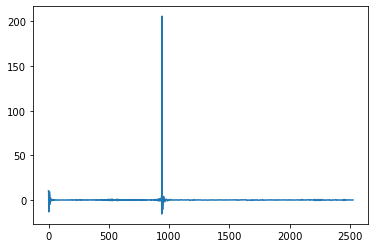

In [16]:
import matplotlib.pyplot as plt
Loss = []
for i in loss:
    Loss.append(i.cpu().detach().numpy())
print(Loss)
plt.plot(Loss)
plt.show()

In [38]:
train_data = data[2527:2527+360]
train_data = torch.tensor(train_data.values).unsqueeze(dim=0)
train_data = train_data.to(torch.float32)
print(train_data)
test_data = data[2527+360:2527+360+30]
test_data = test_data["close"].values.tolist()
print(test_data) # 实际数据

tensor([[[ 0.5781,  0.5859,  0.5908,  ...,  0.4881,  0.1590,  0.1953],
         [ 0.6250,  0.6445,  0.6350,  ...,  0.9977,  0.3989,  0.5358],
         [ 0.6657,  0.6607,  0.6577,  ..., -0.0949,  0.2332,  0.3178],
         ...,
         [ 0.4964,  0.4857,  0.4955,  ...,  0.0137,  0.1382,  0.1401],
         [ 0.4948,  0.4855,  0.4960,  ..., -0.0874,  0.1751,  0.1788],
         [ 0.4788,  0.4666,  0.4742,  ..., -0.3244,  0.2263,  0.2201]]])
[0.46409808164175775, 0.45249870622351107, 0.4567369395494089, 0.45294483604728975, 0.454283225518626, 0.463651951817979, 0.47993569038590234, 0.4681132500557662, 0.4672209904082088, 0.4667748605844301, 0.46342888690608974, 0.45718306937318764, 0.4627596921704216, 0.47034389917465985, 0.4603059781396387, 0.4482604728976133, 0.4504911220165068, 0.4359919027436985, 0.4420146553647112, 0.43376125362480483, 0.427069306268124, 0.42818463082757086, 0.4417915904528218, 0.44870660272139196, 0.4482604728976133, 0.45272177113540046, 0.4482604728976133, 0.4466990

In [39]:
output = net(train_data.cuda())
output = output.squeeze(0)
output = torch.index_select(output.cuda(), dim=0, index=torch.tensor([359]).cuda())
output = output.squeeze(0)
# print(output)
pred = []
for i in output:
    pred.append(i.cpu().detach().numpy())
pred = list(pred)
print(pred) # 预测数据

[array(0.49655724, dtype=float32), array(0.43381622, dtype=float32), array(0.41705656, dtype=float32), array(0.45289484, dtype=float32), array(0.46814358, dtype=float32), array(0.4578891, dtype=float32), array(0.47241893, dtype=float32), array(0.49042273, dtype=float32), array(0.49428147, dtype=float32), array(0.46932232, dtype=float32), array(0.46023867, dtype=float32), array(0.45377928, dtype=float32), array(0.45063737, dtype=float32), array(0.4545335, dtype=float32), array(0.4625768, dtype=float32), array(0.4822778, dtype=float32), array(0.46726823, dtype=float32), array(0.44757083, dtype=float32), array(0.42031568, dtype=float32), array(0.40445268, dtype=float32), array(0.41169354, dtype=float32), array(0.43603447, dtype=float32), array(0.43596578, dtype=float32), array(0.445336, dtype=float32), array(0.46604007, dtype=float32), array(0.462017, dtype=float32), array(0.45357585, dtype=float32), array(0.4559738, dtype=float32), array(0.44222066, dtype=float32), array(0.4420765, dtype

In [40]:
train_data = data[2527:2527+360]
train_data = train_data["close"].values.tolist()
print(train_data)

[0.5972678340397056, 0.657049230426054, 0.6508034128931519, 0.6414346865937989, 0.6490188935980371, 0.6980931742136962, 0.6534801918358243, 0.6534801918358243, 0.7043389917465983, 0.7043389917465983, 0.7038928619228195, 0.7404755074726747, 0.7476135846531342, 0.7411447022083426, 0.723968703992862, 0.743821481151015, 0.7192843408431854, 0.7456060004461299, 0.7420369618559002, 0.7554208565692616, 0.7567592460405979, 0.7335604952041045, 0.7404755074726747, 0.7411447022083426, 0.7391371180013384, 0.7565361811287086, 0.771704595137185, 0.8149791880437207, 0.8241248494311846, 0.8212250055766228, 0.805164331920589, 0.8149791880437207, 0.7569823109524871, 0.8172098371626144, 0.773042984608521, 0.800256903859023, 0.8339397055543164, 0.8850215703769797, 0.8312629266116441, 0.838624068703993, 0.8297014722284186, 0.8410777827347758, 0.8687378318090565, 0.8586999107740353, 0.904428217711354, 0.8912673879098818, 0.9358803702877538, 0.9367726299353112, 0.9454721614989963, 0.9146892036582646, 0.896620

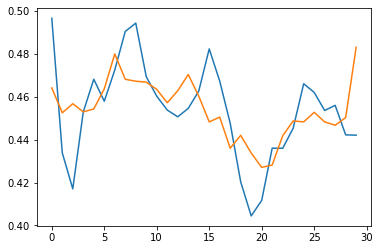

In [43]:
x1 = range(1, 361)
x2 = range(361, 390)
plt.plot(pred)
plt.plot(test_data)
plt.show()